In [ ]:
!pip install ts2vg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 13.2 MB/s 


In [ ]:
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 26.0 MB/s 


In [ ]:
!pip install pycairo
!pip install cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 9.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  ERROR: Failed building wheel for pycairo
Failed to build pycairo
ERROR: Could not build wheels for pycairo which use PEP 517 and cannot be installed directly
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 7.0 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.4.0-py3-none-any.whl size=88775 sha256=911c073c5f5f49e1307dc975f2030138b3f5fb1a0326cb76ca6b2bcdead34010
  Stored in directory: /root/.cache/pip/wheels/01/a9/c0/5c05f9dd73c21f9a7716690642823cdba55594d17a9bd69daf
Successfully built cairocffi


In [ ]:
!rm -rf "/content/FDA_Project2"

In [ ]:
import os
import zipfile
sub_list = os.listdir('/content/drive/MyDrive/FDA Data Sets Zipped')     #getting the list of directories under master folder- FDA Data Sets Zipped
for i in sub_list:                                                  
  pos_dir ='/content/drive/MyDrive/FDA Data Sets Zipped' + '/' + i       #building the folder with subjects
  pos_list = os.listdir('/content/drive/MyDrive/FDA Data Sets Zipped' + '/' + i)   #getting the list of directories under Subjects
  for j in pos_list:
    with zipfile.ZipFile(pos_dir + '/' + j, 'r') as zip_ref:         #creating a zip preference object to unzip the zipped folders
      index = 0
      for info in zip_ref.infolist():                            #loop for unzipping the zipped folders under zipped folders
        if 'zip' in info.filename:
          if index!=1:                                      #to restrict reading upto only one file for a sensor position given for a subject
            zip_ref.extractall('/content/FDA_Project2' + '/' + i + j[:-4])    #extract the files into output folder
            with zipfile.ZipFile('/content/FDA_Project2' + '/' + i + j[:-4] + '/' + info.filename, 'r') as zip_ref1:
              zip_ref1.extractall('/content/FDA_Project2' + '/' + i + '/' + j[:-4])
              os.remove('/content/FDA_Project2' + '/' + i + j[:-4] + '/' + info.filename)   #remove the zipped folder as we no longer require them
              
            index = 1
        else:
          zip_ref.extractall('/content/FDA_Project2'+ '/' + i + '/' + j[:-4])

**Preparing the Data**

In [ ]:


import pandas as pd
import os
from ts2vg import NaturalVG, HorizontalVG
import numpy as np

results = pd.DataFrame(columns=['Method',                 #creating a dataframe with the required data columns
                               'Subject', 
                               'Accelerometer axis', 
                               'Average degree', 
                               'Network diameter',
                               'Average path length',
                               'Activity',
                                'Sensor'])
methods = ["HVG", "NVG"]                                #Methods that are used are Horizontal Visibility Graph and Natural Visibility Graph
acc_axis = ["attr_x", "attr_y", "attr_z"]            #All three axes that are to be considered
path = '/content/FDA_Project2'                     #output folder from where the datasets should be read
for method in methods:                             #looping through each method 
  for i in os.listdir(path):                       #looping through each subject

    if len(i)==8 or len(i)==9:                    #to make sure we are reading files form subject folders rather than some unwanted unzipped folders
      path2 = path + '/' + i
      for j in os.listdir(path2):                 #looping through Activities
        path3 = path2 + '/' + j                   #constructing the path along with activity folder
        for k in os.listdir(path3):               
          for axis in acc_axis:                    #looping through all three axes
            if 'head' in k or 'chest' in k:         #restricting the csv files to either chest or head
              final_path = path3 + '/' + k          #constructing the final path that has csv file that needs to be read
              df = pd.read_csv(final_path)            # Reading the csv file
              g = NaturalVG() if (method == "NVG") else HorizontalVG()   # creating the method object
              g.build(df.loc[1000:2049,axis])                  # appyling the method to selected data
              ig_g = g.as_igraph()                            
              results.loc[results.shape[0]] = {                # Appending the final results to a Dataframe
                  'Method': method, 
                  'Subject': i, 
                  'Accelerometer axis': axis, 
                  'Average degree': np.mean(ig_g.degree()),            
                  'Network diameter': ig_g.diameter(),
                  'Average path length': ig_g.average_path_length(),
                  'Activity': k.split('_')[1],
                  'Sensor': k.split('_')[2].split('.')[0]
                  }
    else:
        continue
results
        


,Method,Subject,Accelerometer axis,Average degree,Network diameter,Average path length,Activity,Sensor
0,HVG,Subject1,attr_x,3.946667,35,16.565140,walking,head
1,HVG,Subject1,attr_y,3.967619,24,10.117280,walking,head
2,HVG,Subject1,attr_z,3.940952,34,14.601445,walking,head
3,HVG,Subject1,attr_x,3.960000,27,11.728625,walking,chest
4,HVG,Subject1,attr_y,3.954286,22,10.761333,walking,chest
...,...,...,...,...,...,...,...,...
715,NVG,Subject7,attr_y,12.956190,14,5.387856,climbingdown,chest
716,NVG,Subject7,attr_z,7.693333,10,4.696186,climbingdown,chest
717,NVG,Subject7,attr_x,8.255238,11,5.098140,climbingdown,head
718,NVG,Subject7,attr_y,12.956190,12,4.589280,climbingdown,head


**Position Head**

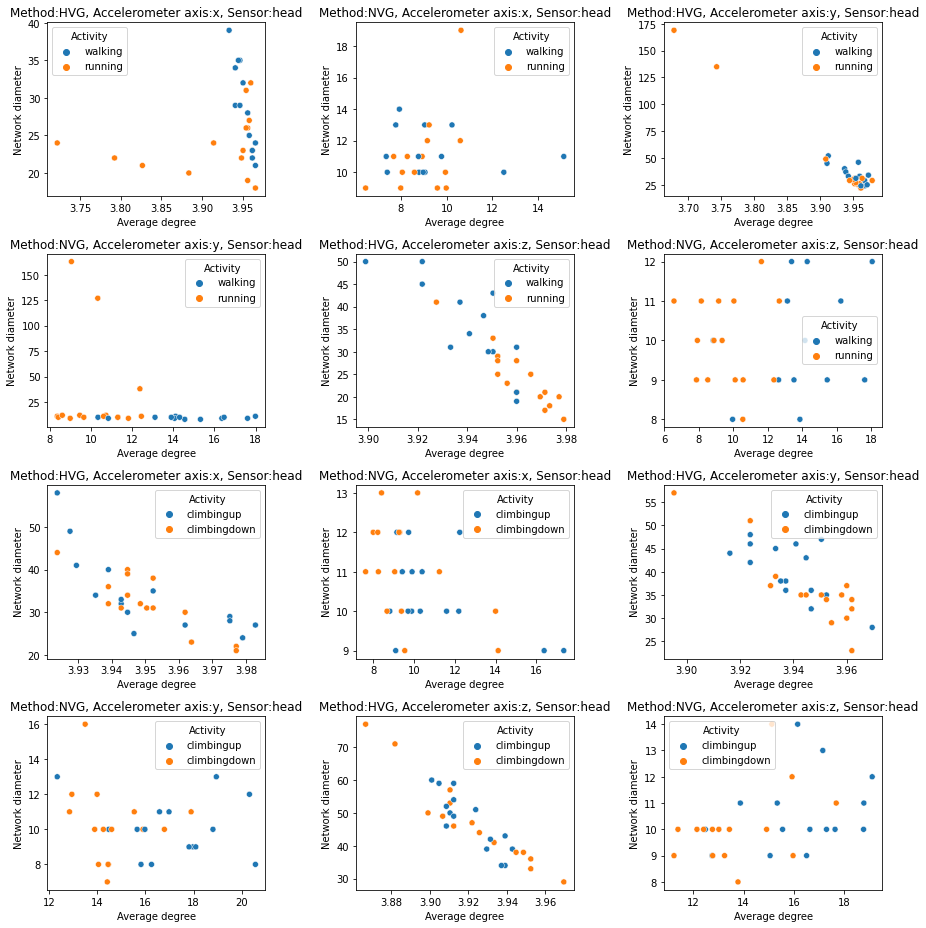

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
axis = ["attr_x", "attr_y", "attr_z"]
methods = ["HVG", "NVG"]
activities = [["walking", "running"], ["climbingup", "climbingdown"]]
sensors = ['head','chest']

fig = plt.figure(figsize=(13, 13))
sub_plot_index = 1

for activity in activities:                   # Looping through activity column to differentiate different activities
  for ax in axis:                             #looping through three axes
    for method in methods:                      #looping through methods i.e. HVG AND NVG
      fig.add_subplot(4, 3, sub_plot_index)                  
      data = results[(results['Accelerometer axis'] == ax) &             #creating a dataframe with different column results for all axes
                       (results['Method'] == method) &                  #choosing both the methods i.e. HVG and NVG
                      (results['Sensor'] == 'head') &             #restricting only for head sensor
                      ((results['Activity'] == activity[0]) | (results['Activity'] == activity[1]))]
      sns.scatterplot(data=data, x='Average degree', y='Network diameter', hue='Activity')        #plotting the dataframe using scatterplot
      plt.title(f"Method:{method}, Accelerometer axis:{ax[5]}, Sensor:head")
      sub_plot_index += 1
fig.tight_layout()
plt.show()

**Position Chest**

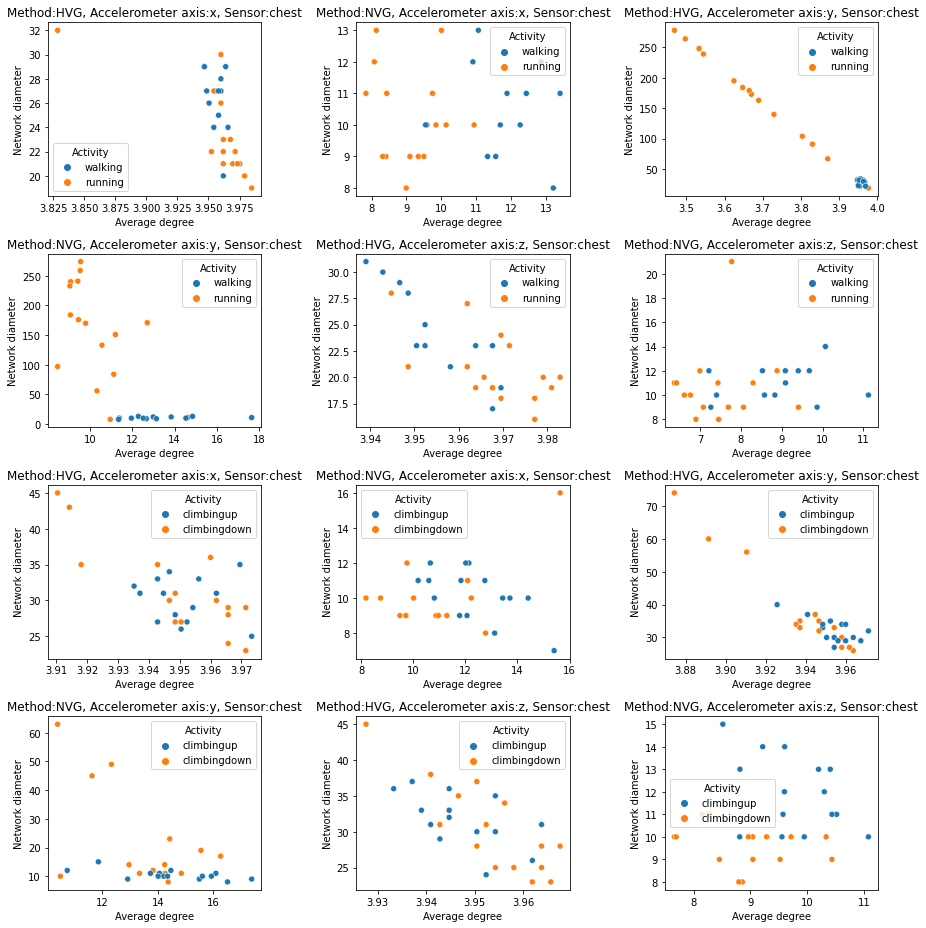

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
axis = ["attr_x", "attr_y", "attr_z"]
methods = ["HVG", "NVG"]
activities = [["walking", "running"], ["climbingup", "climbingdown"]]
sensors = ['head','chest']

fig = plt.figure(figsize=(13, 13))
sub_plot_index = 1

for activity in activities:                      # Looping through activity column to differentiate different activities
  for ax in axis:                                 #looping through three axes
    for method in methods:                         #looping through methods i.e. HVG AND NVG
      fig.add_subplot(4, 3, sub_plot_index)
      data = results[(results['Accelerometer axis'] == ax) &                #creating a dataframe with different column results for all axes
                       (results['Method'] == method) &                     #choosing both the methods i.e. HVG and NVG
                      (results['Sensor'] == 'chest') &                       #restricting only for chest sensor
                      ((results['Activity'] == activity[0]) | (results['Activity'] == activity[1]))]
      sns.scatterplot(data=data, x='Average degree', y='Network diameter', hue='Activity')      #plotting the dataframe using scatterplot
      plt.title(f"Method:{method}, Accelerometer axis:{ax[5]}, Sensor:chest")
      sub_plot_index += 1
fig.tight_layout()
plt.show()

**TASK 2**

In [ ]:
''' This module has essential functions supporting
fast and effective computation of permutation entropy and
its different variations.'''

def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*m-1):, :] 
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:]) 
    

def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*m-1):, :] 
    xm = np.mean(partition, axis=1)
    weight = np.mean((partition - xm[:, None])**2, axis=1)
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = sum(weight[i == idx])

    return list(counts[counts != 0]) 

In [ ]:

import pandas as pd
import os
import numpy as np

results2 = pd.DataFrame(columns=['Subject',                        #creating a dataframe with the required data columns
                               'Accelerometer axis', 
                               'Signal length', 
                               'Dimension',
                               'Delay',
                               'Permutation entropy',
                               'Complexity',
                               'Activity',
                               'Sensor'])

embedded_dimension = [3, 4, 5, 6]                                  #embedded dimension is cosidered in the range of values 3-6
embedded_delay = [1, 2, 3]                                         #embedded delay is restricted to the range of 1-3
signal_length = [1024, 2048, 4096]                                 #signal length is taken as 1024, 2048,4096
methods = ["HVG", "NVG"]                                           #Methods that are used are Horizontal Visibility Graph and Natural Visibility Graph                                  
acc_axis = ["attr_x", "attr_y", "attr_z"]                          #All three axes that are to be considered
path = '/content/FDA_Project2'

for i in os.listdir(path):
  if len(i)==8 or len(i)==9:                                       #to make sure we are reading files form subject folders rather than some unwanted unzipped folders
    path2 = path + '/' + i
    for j in os.listdir(path2):                                    #looping through Activities
      path3 = path2 + '/' + j                                      #constructing the path along with activity folder                                  
      for k in os.listdir(path3):
        for ax in acc_axis:                                        #looping through the axes
          for e_dim in embedded_dimension:                         #looping through the different values of embedded dimension
            for e_del in embedded_delay:                           #looping through the values of embedded delay
              for s_len in signal_length:                          #looping through the values of signal length
                if 'head' in k or 'chest' in k:                    #restricting the csv files to either chest or head
                  final_path = path3 + '/' + k                     #constructing the final path that has csv file that needs to be read
                  df = pd.read_csv(final_path)                     #Reading the csv file
                  op = ordinal_patterns(df[ax][0:s_len], e_dim, e_del)
                  results2.loc[results2.shape[0]] = {                   # Appending the final results to a Dataframe
                      'Subject': i, 
                      'Accelerometer axis': ax, 
                      'Signal length': s_len, 
                      'Dimension': e_dim, 
                      'Delay': e_del,
                      'Permutation entropy': p_entropy(op),
                      'Complexity': complexity(op),
                      'Activity': k.split('_')[1],
                      'Sensor': k.split('_')[2].split('.')[0]
                      }
    else:
      continue
results2

,Subject,Accelerometer axis,Signal length,Dimension,Delay,Permutation entropy,Complexity,Activity,Sensor
0,Subject1,attr_x,1024,3,1,0.775745,0.171051,walking,head
1,Subject1,attr_x,2048,3,1,0.812402,0.148358,walking,head
2,Subject1,attr_x,4096,3,1,0.806786,0.150961,walking,head
3,Subject1,attr_x,1024,3,2,0.879580,0.101684,walking,head
4,Subject1,attr_x,2048,3,2,0.893691,0.090736,walking,head
...,...,...,...,...,...,...,...,...,...
12955,Subject7,attr_z,2048,6,2,0.905822,0.163715,climbingdown,head
12956,Subject7,attr_z,4096,6,2,0.889335,0.193419,climbingdown,head
12957,Subject7,attr_z,1024,6,3,0.942903,0.107230,climbingdown,head
12958,Subject7,attr_z,2048,6,3,0.924668,0.142736,climbingdown,head


**For only Head, for Signal Length=4096, delay=1, embedded_dim = [3,4,5,6]**

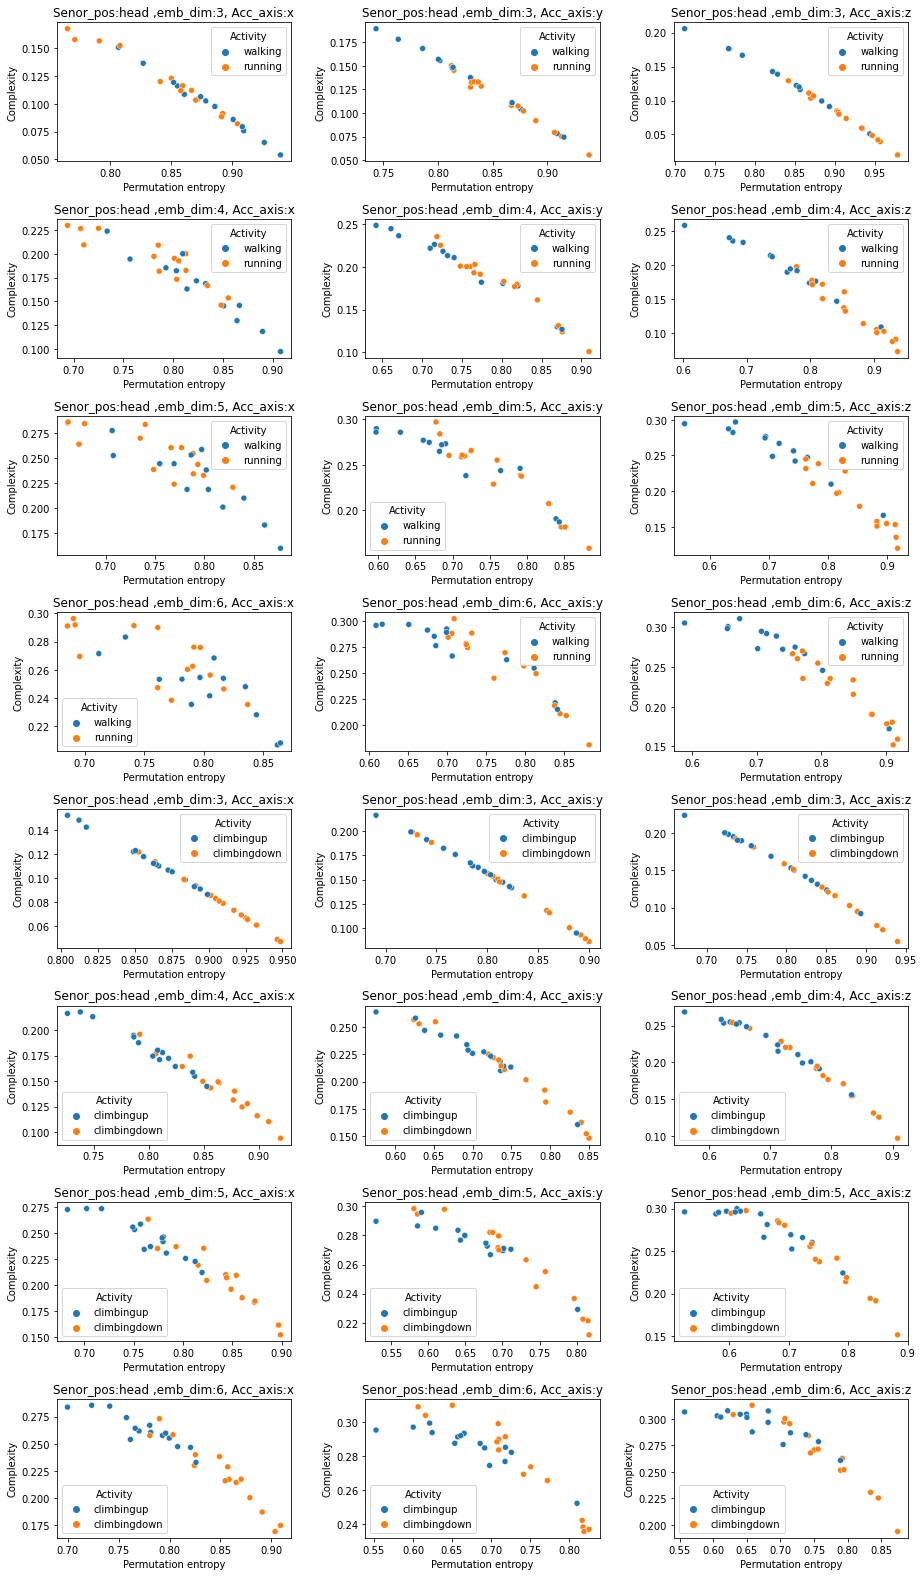

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
axis = ["attr_x", "attr_y", "attr_z"]                                           #specifying the axes 
embedded_dimension = [3, 4, 5, 6]                                               #defining the embedded_dimension as 3,4,5,6
# methods = ["HVG", "NVG"]
activities = [["walking", "running"], ["climbingup", "climbingdown"]]           #defining the activities
sensors = ['head','chest']                                                      #specifying the sensors as head and chest

fig = plt.figure(figsize=(13, 22))
sub_plot_index = 1

for activity in activities:                                                     #looping through activity column to differentiate different activities
  for dimension in embedded_dimension:                                          #looping through the dimensions
    for ax in axis:                                                             #looping through the 3 axes
      fig.add_subplot(8, 3, sub_plot_index)
      data = results2[(results2['Accelerometer axis'] == ax) &                  #creating a dataframe with different column results for all axes
                       (results2['Signal length'] == 4096) &                    #considering signal length as 4096
                      (results2['Delay'] == 1) &                                #considering the delay as 1
                      (results2['Dimension'] == dimension) &
                      (results2['Sensor'] == 'head') &                          #considering the sensor as head
                      ((results2['Activity'] == activity[0]) | (results2['Activity'] == activity[1]))]
      sns.scatterplot(data=data, x='Permutation entropy', y='Complexity', hue='Activity')   #plotting the dataframe using scatterplot
      plt.title(f"Senor_pos:head ,emb_dim:{dimension}, Acc_axis:{ax[5]}")
      sub_plot_index += 1
fig.tight_layout()
plt.show()

**For only Chest, for Signal Length=4096, delay=1, embedded_dim = [3,4,5,6]**

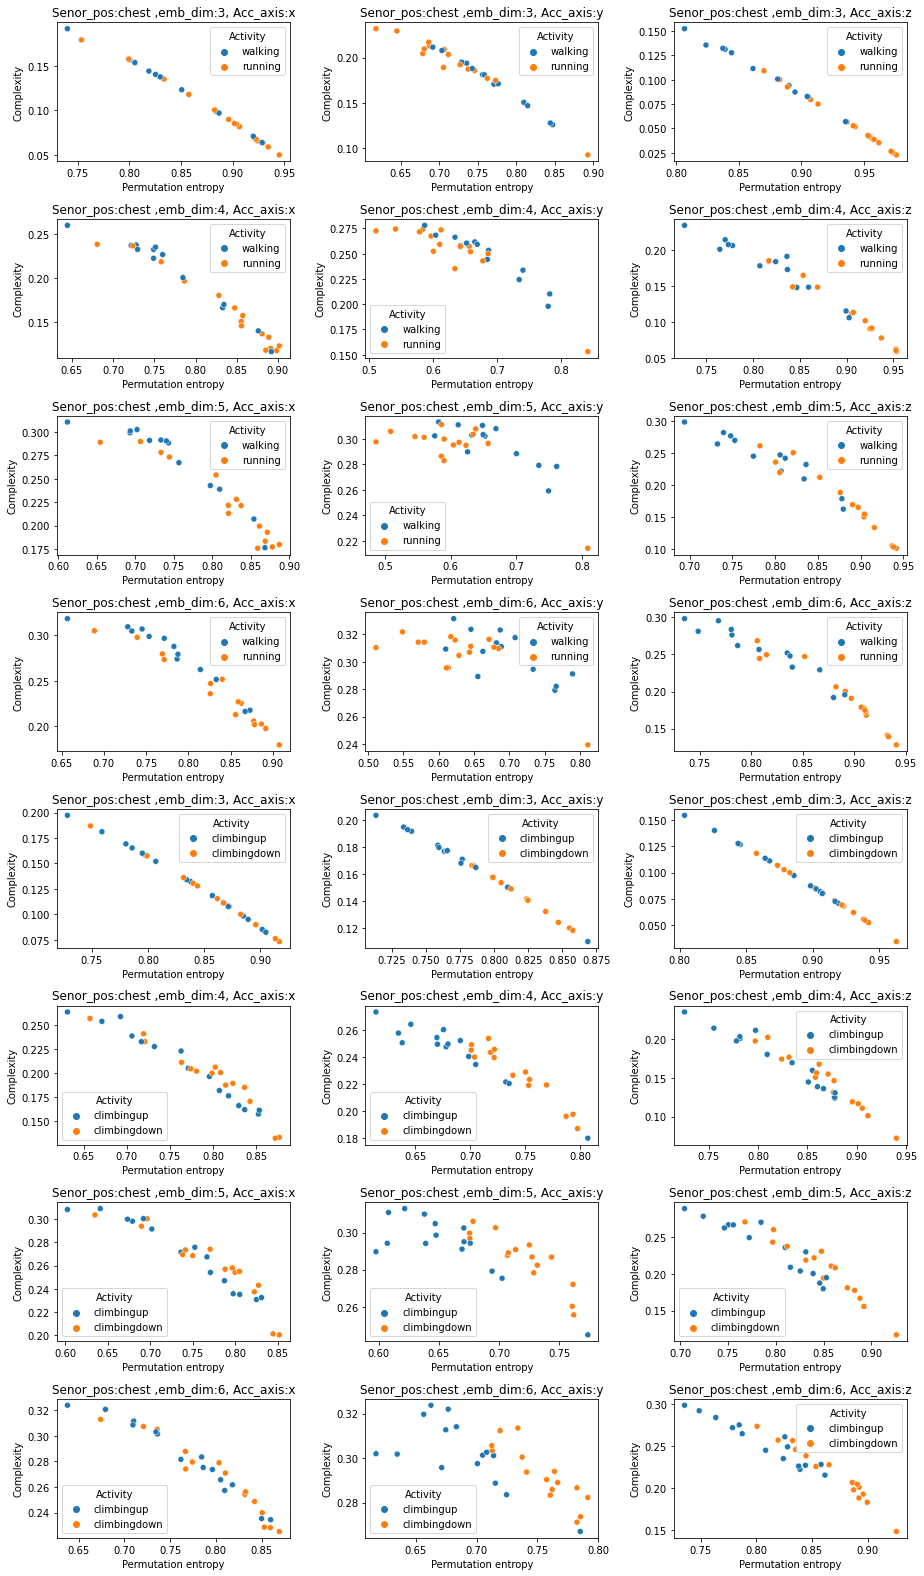

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
axis = ["attr_x", "attr_y", "attr_z"]                                           #specifying the axes 
embedded_dimension = [3, 4, 5, 6]                                               #defining the embedded_dimension as 3,4,5,6
activities = [["walking", "running"], ["climbingup", "climbingdown"]]           #defining the activities
sensors = ['head','chest']                                                      #specifying the sensors as head and chest

fig = plt.figure(figsize=(13, 22))
sub_plot_index = 1

for activity in activities:                                                     #looping through activity column to differentiate different activities
  for dimension in embedded_dimension:                                          #looping through the dimensions
    for ax in axis:                                                             #looping through the 3 axes
      fig.add_subplot(8, 3, sub_plot_index)
      data = results2[(results2['Accelerometer axis'] == ax) &                  #creating a dataframe with different column results for all axes
                       (results2['Signal length'] == 4096) &                    #considering signal length as 4096
                      (results2['Delay'] == 1) &                                #considering the delay as 1
                      (results2['Dimension'] == dimension) &
                      (results2['Sensor'] == 'chest') &                         #considering the sensor as chest
                      ((results2['Activity'] == activity[0]) | (results2['Activity'] == activity[1]))]
      sns.scatterplot(data=data, x='Permutation entropy', y='Complexity', hue='Activity')     #plotting the dataframe using scatterplot
      plt.title(f"Senor_pos:chest ,emb_dim:{dimension}, Acc_axis:{ax[5]}")
      sub_plot_index += 1
      
fig.tight_layout()
plt.show()

**For both head and Chest, for Signal Length=4096, delay=1, embedded_dim = [3,4,5,6]**

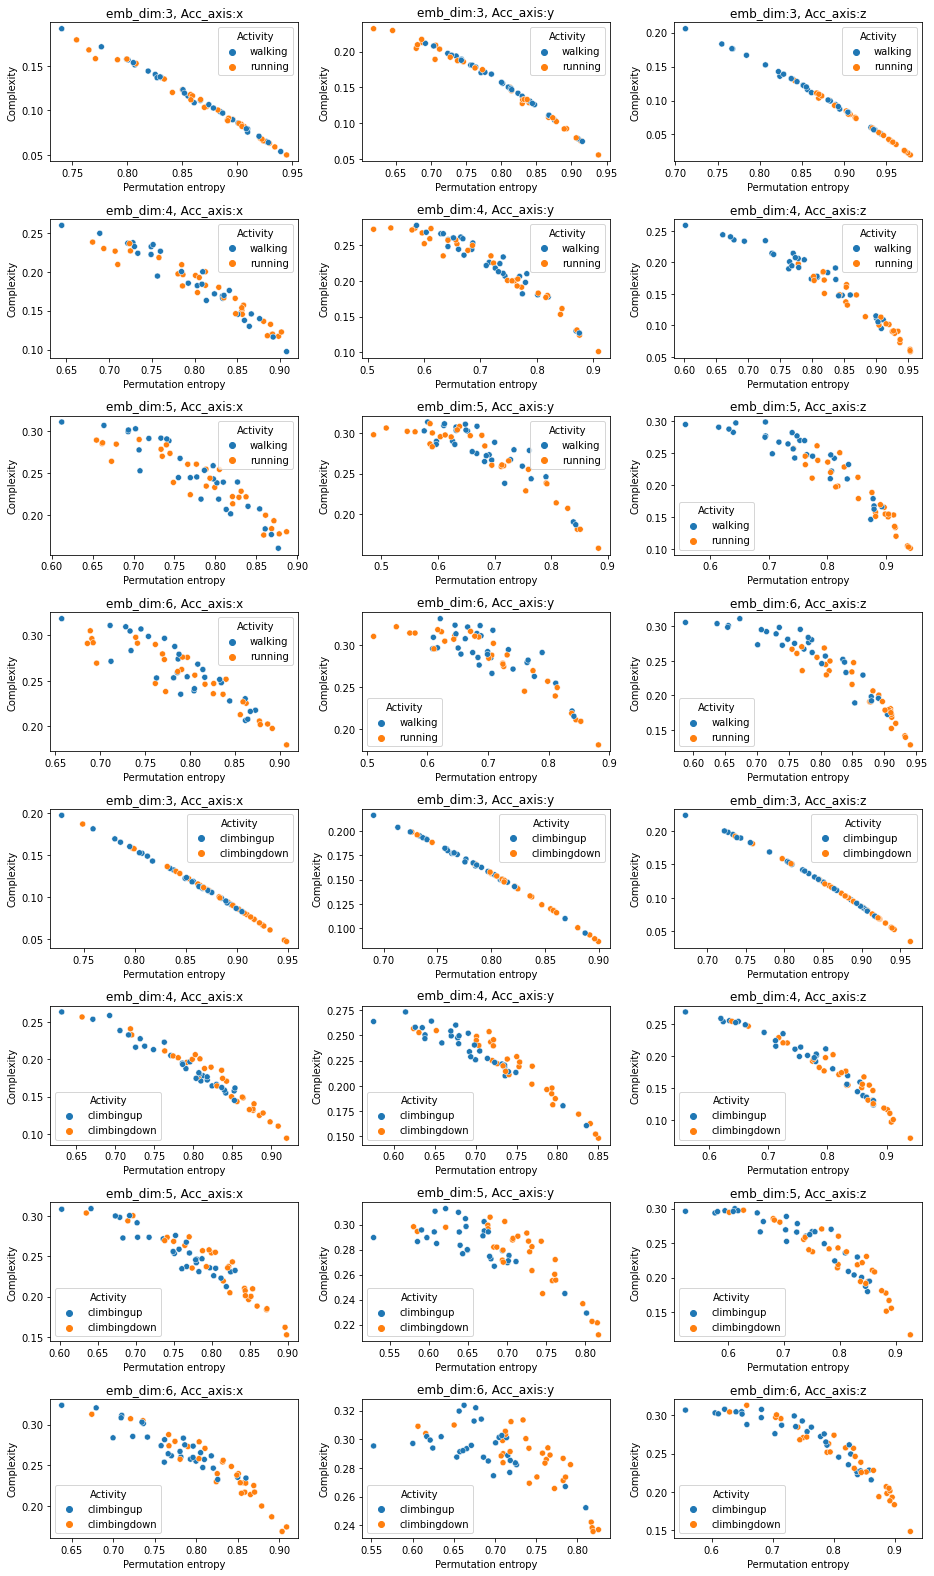

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
axis = ["attr_x", "attr_y", "attr_z"]                                           #specifying the axes 
embedded_dimension = [3, 4, 5, 6]                                               #defining the embedded_dimension as 3,4,5,6
# methods = ["HVG", "NVG"]
activities = [["walking", "running"], ["climbingup", "climbingdown"]]           #defining the activities
sensors = ['head','chest']                                                      #specifying the sensors as head and chest

fig = plt.figure(figsize=(13, 22))
sub_plot_index = 1

for activity in activities:                                                     #looping through activity column to differentiate different activities
  for dimension in embedded_dimension:                                          #looping through the dimensions
    for ax in axis:                                                             #looping through the 3 axes
    # for sensor in sensors:
      fig.add_subplot(8, 3, sub_plot_index)
      data = results2[(results2['Accelerometer axis'] == ax) &                  #creating a dataframe with different column results for all axes
                       (results2['Signal length'] == 4096) &                    #considering signal length as 4096
                      (results2['Delay'] == 1) &                                #considering the delay as 1
                      (results2['Dimension'] == dimension) &
                      # (results2['Sensor'] == 'chest') &
                      ((results2['Activity'] == activity[0]) | (results2['Activity'] == activity[1]))]
      sns.scatterplot(data=data, x='Permutation entropy', y='Complexity', hue='Activity')  #plotting the dataframe using scatterplot
      plt.title(f"emb_dim:{dimension}, Acc_axis:{ax[5]}")
      sub_plot_index += 1
fig.tight_layout()
plt.show()

In [ ]:
!jupyter nbconvert --to html FDAPROJECT2.ipynb

[NbConvertApp] WARNING | pattern 'FDAPROJECT2.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
   